In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_csv('data.csv', header=None)

In [3]:
raw_data.head()

,0,1,2,3,4,5
0,8:56 AM,9:00 AM,7:45 AM,7:45 AM,8:05 AM,7:45 AM
1,8:40 AM,8:40 AM,8:30 AM,8:30 AM,8:45 AM,8:20 AM
2,8:45 AM,8:20 AM,8:05 AM,8:00 AM,8:05 AM,8:00 AM
3,8:40 AM,8:40 AM,8:40 AM,8:25 AM,8:40 AM,8:40 AM
4,8:55 AM,8:50 AM,8:55 AM,8:10 AM,8:15 AM,8:05 AM


In [4]:
raw_data.values[:3]  # show the first three rows as an array

array([['8:56 AM', '9:00 AM', '7:45 AM', '7:45 AM', '8:05 AM', '7:45 AM'],
       ['8:40 AM', '8:40 AM', '8:30 AM', '8:30 AM', '8:45 AM', '8:20 AM'],
       ['8:45 AM', '8:20 AM', '8:05 AM', '8:00 AM', '8:05 AM', '8:00 AM']],
      dtype=object)

### Put the data in a single array

In [5]:
data = raw_data.values.reshape(-1)
data.shape

(138,)

In [6]:
data[:10], data[-10:]  # show the beginning and the end of data

(array(['8:56 AM', '9:00 AM', '7:45 AM', '7:45 AM', '8:05 AM', '7:45 AM',
        '8:40 AM', '8:40 AM', '8:30 AM', '8:30 AM'], dtype=object),
 array(['9:00 AM', '8:57 AM', '8:57 AM', '8:50 AM', '8:45 AM', '8:50 AM',
        '8:30 AM', '8:45 AM', '8:50 AM', '8:10 AM'], dtype=object))

In [7]:
def convert_time_to_minutes(time_text: str) -> int:
    """Converts time formatted as 'H:MM AM' to minutes before/after 9:00 AM"""
    try:
        time_text = time_text.strip()  # remove any unexpected spaces
        hours_minutes, _, am_pm = time_text.partition(' ')
        hours, _, minutes = hours_minutes.partition(':')
        hours = int(hours)
        hours -= 9  # 9:00 AM is zero
        if am_pm[0].lower() == 'p':
            hours += 12
        minutes = int(minutes)
        return hours*60 + minutes
    except ValueError:
        return None

In [8]:
# should be 0
convert_time_to_minutes("9:00 am")

0

In [9]:
# should be -3
convert_time_to_minutes("8:57 am")

-3

In [10]:
# should be 240
convert_time_to_minutes("1:00 pm")

240

In [11]:
# should be 180
convert_time_to_minutes("12:00 pm")  # why is this an edge case?

900

In [12]:
pd.Timestamp('july 4, 1776')

Timestamp('1776-07-04 00:00:00')

### Oops!
Maybe we shouldn't write our own time logic.

#### Note: there are two things in Python you _never_ want to reinvent from scratch:

1. CSV parsing: use `csv.reader` or `pd.read_csv`
2. Time/date logic: use `pd.Timestamp` or `datetime.datetime`

In [13]:
def convert_time_to_minutes(time_text: str) -> int:
    """Converts time formatted as 'H:MM AM' to minutes before/after 9:00 AM"""
    try:
        time_delta = pd.Timestamp(time_text) - pd.Timestamp("9:00 am")
        return int(time_delta.total_seconds() / 60)
    except ValueError:
        return None
    

In [14]:
minutes_early_or_late = [convert_time_to_minutes(time_text) for time_text in data]

In [15]:
y = [value for value in minutes_early_or_late if value is not None]  # drop missing/None values

In [16]:
x_label = 'Minutes (negative is early, zero is on time, positive is late)'
y_label = 'Count'
hist_title = 'Student On-Time Performance'

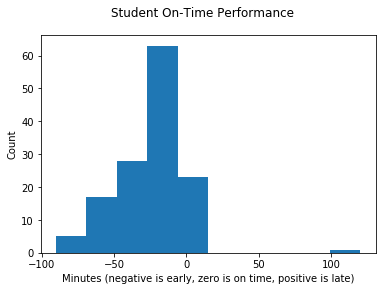

In [17]:
fig, ax = plt.subplots()
ax.hist(y)  # Use the default number of bins
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.suptitle(hist_title)
plt.show()

That's not bad, but maybe more detail would be interesting!

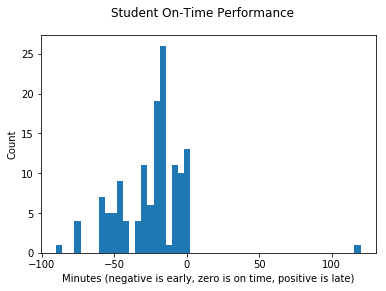

In [18]:
fig, ax = plt.subplots()
ax.hist(y, bins=50)  # More bins is better, right?
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.suptitle(hist_title)
plt.show()

That seems a bit too sparse.

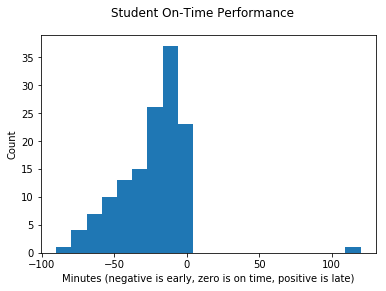

In [19]:
fig, ax = plt.subplots()
ax.hist(y, bins=20)  # Let's try something in between
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.suptitle(hist_title)
plt.show()

# Daily Challenge

Objectives/Questions:

* What type of distribution does the arrival time data most likely follow?
* Write a program that simulates the distribution using scipy.

## Type of Distribution
I think that the type of distribution that most likely resulted in this set of data is an exponential distribution rather than a normal distribution. One reason is that exponential distributions depends on time between a fixed point (start time) and an event (arrival time). This shows the more students tend to arrive early, but not that early for class. 

On the other hand, the normal distribution would assume that with more and more data points the distribution would become more of a bell curve with the mean shifting towards the center which currently would mean that that people tend to arrive about an hour before the start of class. 

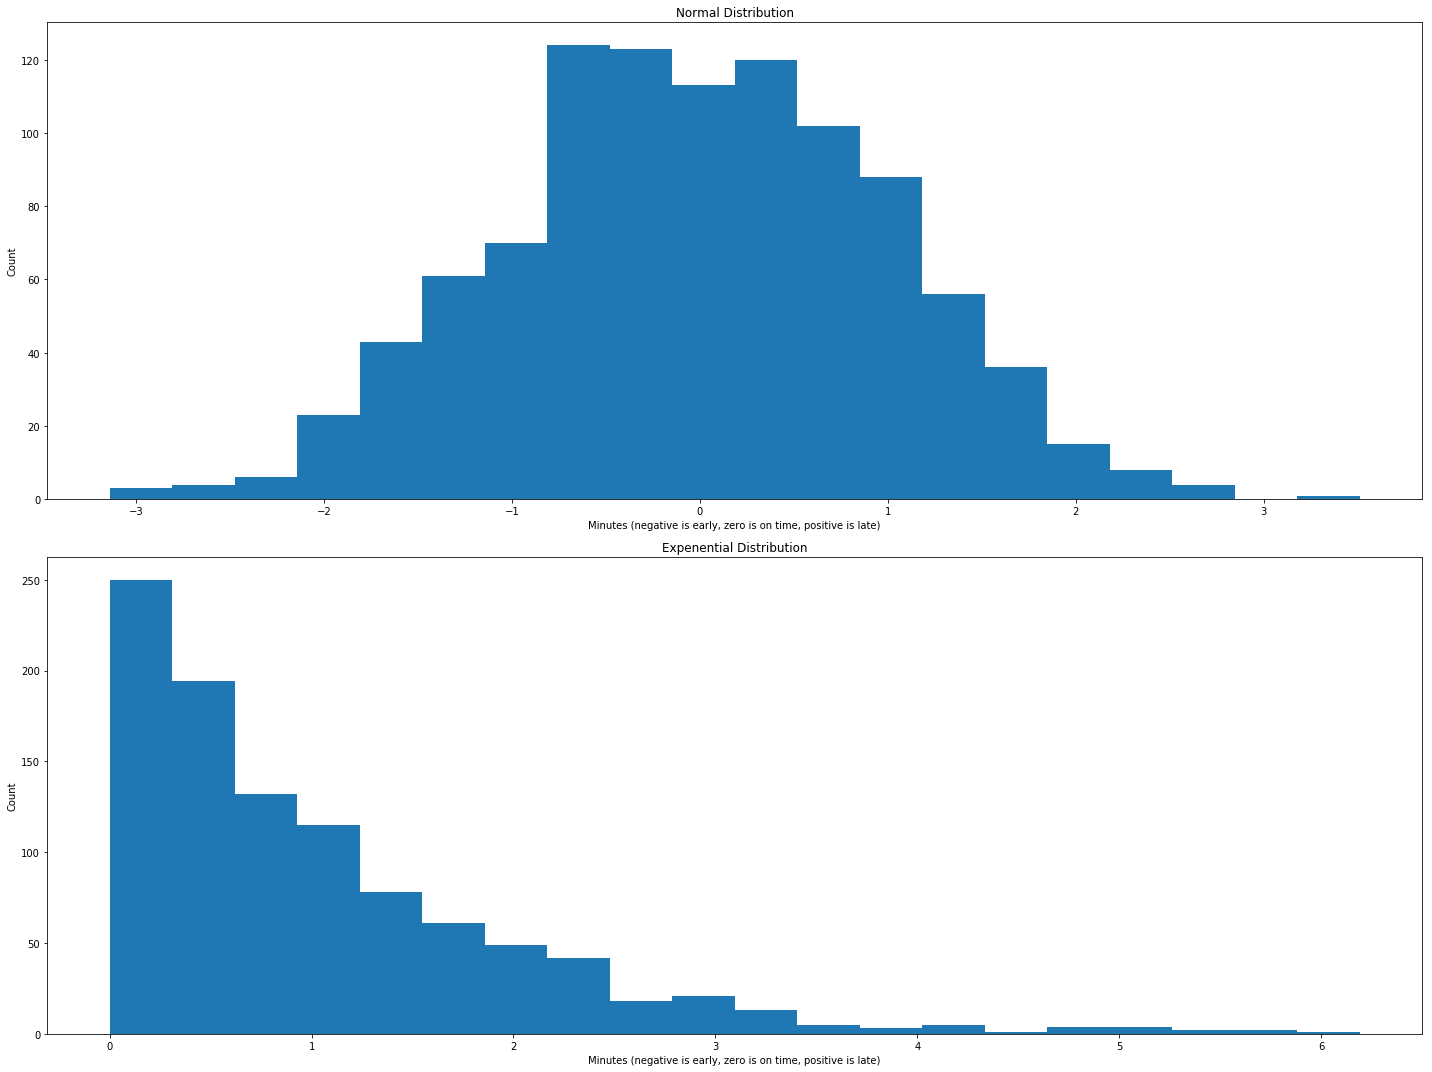

In [20]:
from scipy import stats

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

# Create some fake data with a normal distribution
normal_dist = stats.norm(loc=0, scale=1)
fake_y = normal_dist.rvs(1000)  

# Plot the data from the normal distribution
ax = axs[0]
ax.hist(fake_y, bins=20)  # Let's try something in between
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Normal Distribution")

# Create some fake data with an exponential distribution
exponential_dist = stats.expon(loc=0, scale=1)
fake_y = exponential_dist.rvs(1000)  

# Plot the data from the exponential distribution
ax = axs[1]
ax.hist(fake_y, bins=20)  # Let's try something in between
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title("Expenential Distribution")

# Show the plots
plt.tight_layout()
plt.show()

By looking at the graphs of a typical normal and exponential distribution, I can see that our arrival time data looks more like the exponential, but our data is flipped over the y-axis such that we have negative arrival times.

## Simulation of Arrival Times

Let's make some changes to generate a distribution that looks like our arrival times.

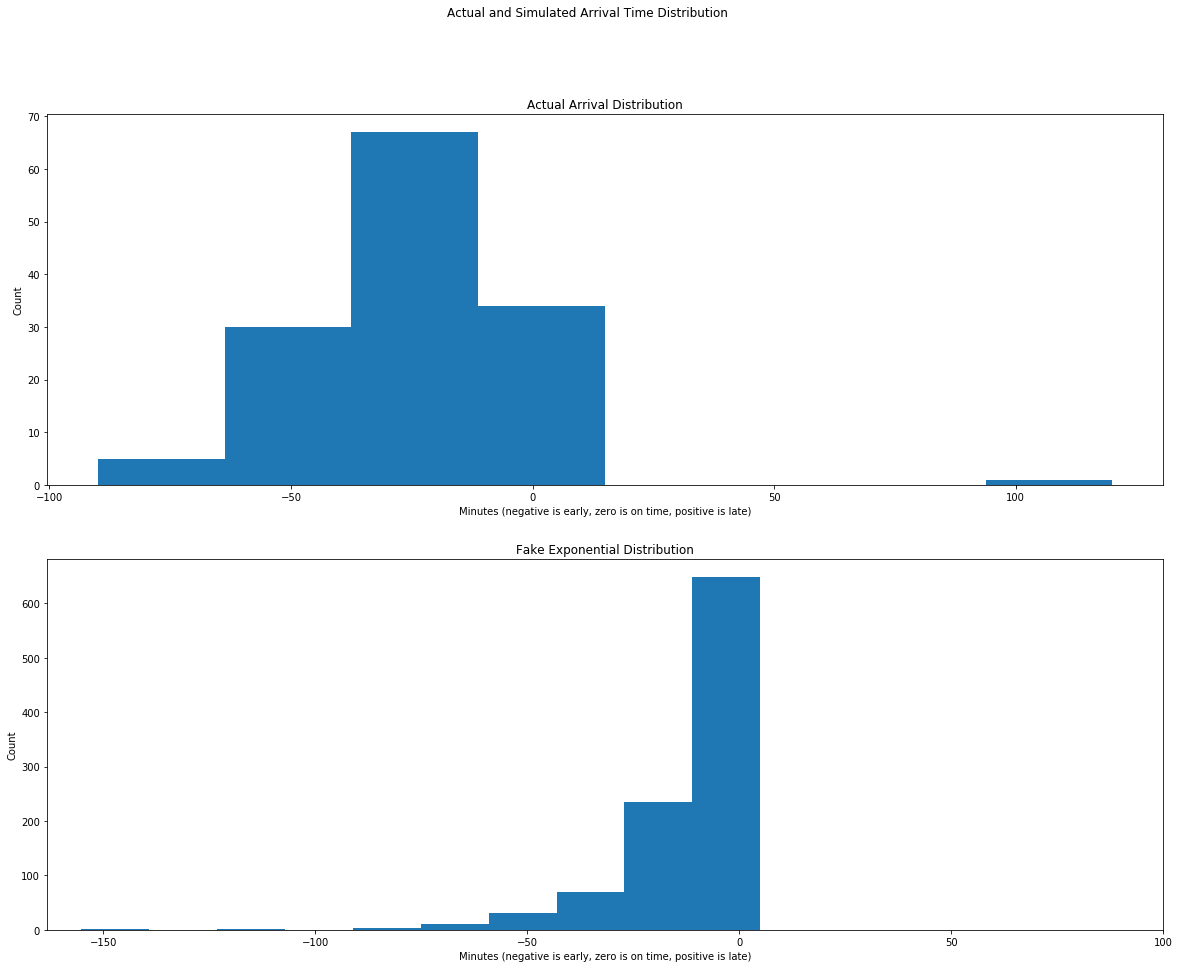

<Figure size 432x288 with 0 Axes>

In [52]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

# Create some fake data with an exponential distribution
exponential_dist = stats.expon(loc=-5, scale=15)
fake_y = -1*exponential_dist.rvs(1000)  

# Plot the data from the exponential distribution
ax = axs[1]
ax.hist(fake_y, bins=10)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_xticks((-100, 100), 10)
ax.set_title("Fake Exponential Distribution")


# Plot the actual arrival times
ax = axs[0]
ax.hist(y, bins=8)  # Let's try something in between
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_xticks((-100, 100), 10)
ax.set_title("Actual Arrival Distribution")
fig.suptitle('Actual and Simulated Arrival Time Distribution')
plt.show()

# Show the plots
plt.tight_layout()
plt.show()

While there is still a difference between the actual and the simulated, the shape is roughly similar. The data is increasing in frequency. The simulated data does not take into account tardies, but looking at the majority of the real data looks similar to the exponential distribution with very few arrivals over an hour early and the majority of arrivals within thirty minutes of the start time.